## *Using neural networks to estimate Young's Modulus for elements*

**Why?** Creating regression models from attributes can help scientists, engineers and students get an approximate value for unknown or unmeasured properties of materials.

**What?** In this tutorial we will learn how to use neural networks from the [Keras](https://keras.io/) library to create a regression model to estimate Young's modulus.

You can find another example of neural network regression using Keras in the [TensorFlow Tutorials](https://nanohub.org/tools/tftutorials) nanoHUB tool.

**How to use this?** This tutorial uses Python, some familiarity with programming would be beneficial but is not required. Run each code cell in order by clicking "Shift + Enter". Feel free to modify the code, or change queries to familiarize yourself with the workings on the code.

Suggested modifications and exercises are included in <font color=blue> blue</font>.

**Outline:**

1. Getting data
2. Processing and Organizing Data
3. Creating the Model
4. Plotting


**Get started:** Click "Shift-Enter" on the code cells to run! 

### 1. Getting a dataset

We will repeat the process of obtaining a dataset used in the [previous](MSEML_Regression.ipynb) tutorial and the explanations are repeated for convenience.

Datasets containing properties for the elements in the periodic table are available online; however, it would be thematic to create our own, using the tools from the first tutorial on [MSEML Query_Viz](MSEML_Query_Viz.ipynb). In this section we will query both [Pymatgen](http://pymatgen.org/) and [Mendeleev](https://mendeleev.readthedocs.io/en/stable/) to get a complete set of properties per element. We will use this data to create the cases from which the model will train and test.
<br>
<br>
In this first snippet of code we will import all relevant libraries, the elements that will be turned into cases and the properties that will serve as the attributes for the cases. We will get 49 entries (which is a small dataset), but should give us a somewhat accurate prediction. We will also include some values to "patch" some unknown values in the dataset. It is important to note that more entries would move the prediction closer to the real value, and so would more attributes.
<br>
<br>
The elements listed were chosen because querying them for these properties yields a dataset with few unknown values, and because they represent the three most common crystallographic structures.

In [1]:
import pymatgen as pymat
import mendeleev as mendel
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

import sys
import os
sys.path.insert(0, '../src/')

%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Kayla Yano\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Kayla Yano\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Kayla Yano\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Kayla Yano\anaconda3\envs\PythonDa

After setting these values, we will proceed with our queries. Depending on the database (either Pymatgen or Mendeleev) where the property can be found, this code fills up a list with the properties of each of the elements. To visualize how the dataset we just created looks, we will use the [Pandas](https://pandas.pydata.org/) library to display it. This library will take the list of lists and show it in a nice, user-friendly table with the properties as the column headers.

In [49]:
df = pd.read_csv(Path('../All Data Export/Ti_compounds_dataframe.csv'))
df

,Unnamed: 0,mp_id,Formula,Composition,IPF,Density,Elastic_Tensor,E_above_Hull,G_VRH,K_VRH,Elastic_Anisotropy,poisson_ratio,Y_Modulus
0,0,mp-1014229,Ti2Zn,"{'Ti': 2.0, 'Zn': 1.0}",0.163919,5.462442,"{'G_Reuss': 29.0, 'G_VRH': 47.0, 'G_Voigt': 65...",0.0,47.0,96.0,6.32,0.29,121.26
1,1,mp-1014230,TiZn,"{'Ti': 1.0, 'Zn': 1.0}",0.174651,6.036543,"{'G_Reuss': 44.0, 'G_VRH': 56.0, 'G_Voigt': 69...",0.0,56.0,115.0,2.85,0.29,144.48
2,2,mp-1017985,TiAg,"{'Ti': 1.0, 'Ag': 1.0}",0.226014,7.340359,"{'G_Reuss': 32.0, 'G_VRH': 35.0, 'G_Voigt': 37...",0.0,35.0,111.0,0.80,0.36,95.20
3,3,mp-1018028,TiS,"{'Ti': 1.0, 'S': 1.0}",0.182130,4.442034,"{'G_Reuss': 97.0, 'G_VRH': 101.0, 'G_Voigt': 1...",0.0,101.0,141.0,0.44,0.21,244.42
4,4,mp-1018123,TiAu2,"{'Ti': 1.0, 'Au': 2.0}",0.248079,14.162674,"{'G_Reuss': -92.0, 'G_VRH': -17.0, 'G_Voigt': ...",0.0,-17.0,130.0,-8.12,0.57,-53.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,333,mp-5999,Sm2Ti2S2O5,"{'Sm': 2.0, 'Ti': 2.0, 'S': 2.0, 'O': 5.0}",0.398389,5.233540,"{'G_Reuss': 54.0, 'G_VRH': 58.0, 'G_Voigt': 62...",0.0,58.0,134.0,0.77,0.31,151.96
333,334,mp-6328,Na2Ti2Sb2O,"{'Na': 2.0, 'Ti': 2.0, 'Sb': 2.0, 'O': 1.0}",0.217025,4.601878,"{'G_Reuss': 27.0, 'G_VRH': 18.0, 'G_Voigt': 10...",0.0,18.0,52.0,-2.81,0.34,48.24
334,335,mp-998980,TiAlFeCo,"{'Ti': 1.0, 'Al': 1.0, 'Fe': 1.0, 'Co': 1.0}",0.170756,6.423142,"{'G_Reuss': 127.0, 'G_VRH': 127.0, 'G_Voigt': ...",0.0,127.0,175.0,0.01,0.21,307.34
335,336,mp-560767,KNaTiO3,"{'K': 1.0, 'Na': 1.0, 'Ti': 1.0, 'O': 3.0}",0.551255,2.952356,"{'G_Reuss': 18.0, 'G_VRH': 26.0, 'G_Voigt': 33...",0.0,26.0,56.0,4.12,0.30,67.60


In [50]:
df.columns

Index(['Unnamed: 0', 'mp_id', 'Formula', 'Composition', 'IPF', 'Density',
       'Elastic_Tensor', 'E_above_Hull', 'G_VRH', 'K_VRH',
       'Elastic_Anisotropy', 'poisson_ratio', 'Y_Modulus'],
      dtype='object')

In [51]:
df.drop( df[ df['Y_Modulus'] < 0 ].index , inplace=True)
df_original = df.copy
elements = df['Formula'].tolist()
df = df.drop(df.columns[[0, 1, 2, 3, 6]], axis=1)
df

,IPF,Density,E_above_Hull,G_VRH,K_VRH,Elastic_Anisotropy,poisson_ratio,Y_Modulus
0,0.163919,5.462442,0.0,47.0,96.0,6.32,0.29,121.26
1,0.174651,6.036543,0.0,56.0,115.0,2.85,0.29,144.48
2,0.226014,7.340359,0.0,35.0,111.0,0.80,0.36,95.20
3,0.182130,4.442034,0.0,101.0,141.0,0.44,0.21,244.42
5,0.148441,7.088660,0.0,82.0,157.0,0.12,0.28,209.92
...,...,...,...,...,...,...,...,...
331,0.401144,5.012983,0.0,54.0,127.0,1.00,0.31,141.48
332,0.398389,5.233540,0.0,58.0,134.0,0.77,0.31,151.96
333,0.217025,4.601878,0.0,18.0,52.0,-2.81,0.34,48.24
334,0.170756,6.423142,0.0,127.0,175.0,0.01,0.21,307.34


### 2. Processing and Organizing Data

Most machine learning models are trained on a subset of all the available data, called the "training set", and the models are tested on the remainder of the available data, called the "testing set". Model performance has often been found to be enhanced when the inputs are normalized.

##### SETS

With the dataset we just created, we have 49 entries for our model. We will train with 44 cases and test on the remaining 5 elements to estimate Young's Modulus.

##### NORMALIZATION

Each one of these input data features has different units and is represented in scales with distinct orders of magnitude. Datasets that contain inputs like this need to be normalized, so that quantities with large values do not *overwhelm* the neural network, forcing it tune its weights to account for the different scales of our input data. In this tutorial, we will use the Standard Score Normalization, which subtracts the mean of the feature and divide by its standard deviation.

<span style="font-size:2em;">$ \frac{X - µ}{σ} $ </span>

While our model might converge without feature normalization, the resultant model would be difficult to train and would be dependent on the choice of units used in the input.

In [52]:
all_values = df.values.tolist() # Values for Attributes
print(all_values)
all_labels = [] # Values for Young's Modulus (Property to be estimated)
all_labels = df['Y_Modulus'].tolist()
df = df.drop(['Y_Modulus'], axis=1)
df.head(n=10)

[[0.1639185929850974, 5.4624418431294846, 0.0, 47.0, 96.0, 6.32, 0.29, 121.26], [0.17465114469285195, 6.036542541370883, 0.0, 56.0, 115.0, 2.85, 0.29, 144.48000000000005], [0.2260142798191104, 7.340358574162901, 0.0, 35.0, 111.0, 0.8, 0.36, 95.2], [0.18213033035592235, 4.442034010283959, 0.0, 101.0, 141.0, 0.44, 0.21, 244.42], [0.14844111420265715, 7.088660453522411, 0.0, 82.0, 157.0, 0.12, 0.28, 209.92], [0.13099301136756655, 4.5575474836855445, 0.0, 213.0, 225.0, 0.12, 0.14, 485.64], [0.1552981353489944, 6.4129856237257545, 0.0, 38.0, 152.0, 10.41, 0.38, 104.88], [0.13122955521003882, 4.439769168464848, 0.0, 78.0, 139.0, 1.07, 0.26, 196.56], [0.14077963316526612, 17.774770707590932, 0.0, 162.0, 294.0, 0.98, 0.27, 411.48], [0.1230849374375109, 4.48742509138872, 0.0, 253.0, 253.0, 0.14, 0.13, 571.78], [0.5600231544369283, 4.187247707142454, 0.0, 76.0, 171.0, 0.5, 0.31, 199.12], [0.18356435194439236, 5.571714611425472, 0.0, 46.0, 84.0, 0.49, 0.27, 116.84], [0.3662168250314958, 5.0129268

,IPF,Density,E_above_Hull,G_VRH,K_VRH,Elastic_Anisotropy,poisson_ratio
0,0.163919,5.462442,0.0,47.0,96.0,6.32,0.29
1,0.174651,6.036543,0.0,56.0,115.0,2.85,0.29
2,0.226014,7.340359,0.0,35.0,111.0,0.80,0.36
3,0.182130,4.442034,0.0,101.0,141.0,0.44,0.21
5,0.148441,7.088660,0.0,82.0,157.0,0.12,0.28
6,0.130993,4.557547,0.0,213.0,225.0,0.12,0.14
7,0.155298,6.412986,0.0,38.0,152.0,10.41,0.38
8,0.131230,4.439769,0.0,78.0,139.0,1.07,0.26
9,0.140780,17.774771,0.0,162.0,294.0,0.98,0.27
10,0.123085,4.487425,0.0,253.0,253.0,0.14,0.13


In [53]:
#We will rewrite the arrays with the patches we made on the dataset 
# by turning the dataframe back into a list of lists

all_values = [list(df.iloc[x]) for x in range(len(all_values))]

# SETS

# List of lists are turned into Numpy arrays to facilitate calculations in steps to follow (Normalization).
all_values = np.array(all_values, dtype = float) 
print("Shape of Values:", all_values.shape)
all_labels = np.array(all_labels, dtype = float)
print("Shape of Labels:", all_labels.shape)

# Uncomment the line below to shuffle the dataset 
#(we do not do this here to ensure consistent results for every run)
#order = np.argsort(np.random.random(all_labels.shape)) 
# This numpy argsort returns the indexes that would be used to shuffle a list
order = np.arange(331)
all_values = all_values[order]
all_labels = all_labels[order]

# Training Set
train_labels = all_labels[:300]
train_values = all_values[:300]

# Testing Set
test_labels = all_labels[-31:]
test_values = all_values[-31:]

# This line is used for labels in the plots at the end of the tutorial - Testing Set

labeled_elements = [elements[x] for x in order[-31:]] 
elements = [elements[x] for x in order]

# NORMALIZATION

mean = np.mean(train_values, axis = 0) # mean
std = np.std(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
test_values = (test_values - mean) / std # input scaling

print(train_values[0]) # print a sample entry from the training set
print(test_values[0]) # print a sample entry from the training set
print(order)

Shape of Values: (331, 7)
Shape of Labels: (331,)
[-0.26365008 -0.49675052 -0.11596706 -0.65583148 -0.83510711  0.21475553
  0.04097274]
[-0.23179244  0.96807878 -0.11596706  0.          0.70368856  0.00112485
  0.6879107 ]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 1

### 3. Creating the Model

For this regression, we will use a simple sequential neural network with one densely connected hidden layer. The optimizer used will be [RMSPropOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer) (Root Mean Square Propagation).

To learn more about Root Mean Squared Propagation, click [here](https://climin.readthedocs.io/en/latest/rmsprop.html).

A cool tool developed by Tensorflow to visualize how a neural network learns, and play around with its parameters, can be found here [NN Tools](https://playground.tensorflow.org/).

In [54]:
# DEFINITION OF THE MODEL

# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
# In a sequential model, the first layer must specify the input shape the model will expect; 
# in this case the value is train_values.shape[1] which is the number
# of attributes (properties) and equals 17.

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init))
model.add(Dense(64, activation='relu', kernel_initializer=kernel_init))
model.add(Dense(64, activation='relu', kernel_initializer=kernel_init))
model.add(Dense(1, kernel_initializer=kernel_init))

# DEFINITION OF THE OPTIMIZER

optimizer = optimizers.RMSprop(0.002) # Root Mean Squared Propagation

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________________


#### TRAINING 

This model is trained for 2000 epochs, and we record the training accuracy in the history object.

One **Epoch** occurs when you pass the entire dataset through the model. One **Batch** contains a subset of the dataset that can be fed to the model at the same time. A more detailed explanation of these concepts can be found in this [blog](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9). As we have a really small dataset compared to the ones that are usually considered to be modeled by these neural networks, we are feeding all entries at the same time, so our batch is the entire dataset, and an epoch occurs when the batch is processed.

This way, by plotting "history" we can see the evolution of the "learning" of the model, that is the decrease of the Mean Absolute Error. Models in Keras are fitted to the training set using the [**fit**](https://keras.io/models/model/#fit) method.

The blue curve that will come up from the History object represents how the model is learning on the training data, and the orange curve represents the validation loss, which can be thought of as the way our model evaluates data that it was not trained in. This validation loss would start going up again when we start to overfit our data.

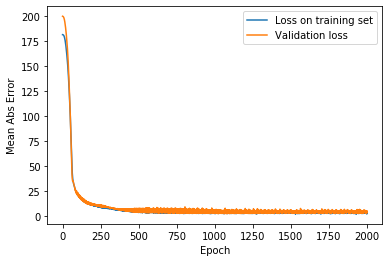

In [55]:
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(tf.keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') + '                                       \r') # Updates current Epoch Number

EPOCHS = 2000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),label = 'Validation loss')
plt.legend()
plt.show()

#### SAVING A MODEL

Compiled and trained models in Keras can be saved and distributed in .h5 files using the `model.save()` method. Running the cell below will save the current model we trained, both weights and architecture to your home directory.

In [56]:
model.save(os.path.expanduser('~/model.h5'))

#### TESTING

Models in Keras are tested using the method [**evaluate**](https://keras.io/models/model/#evaluate). This method returns the testing loss of the model and the metrics we specified when creating it,  which in our case it's the Mean Absolute Error. For the original model in this tutorial you should get a value of around **20 GPa** for the Mean Absolute Error. This value would decrease with more training data, more attributes/features, or a different optimizer. In the case of a model that overfits, you can expect values to start increasing to around **30 or 40 GPa**.

In [57]:
[loss, mae] = model.evaluate(test_values, test_labels, verbose=0)

print("Testing Set Mean Absolute Error: {:2.3f} GPa".format(mae))

Testing Set Mean Absolute Error: 3.679 GPa


In [58]:
tf.summary

<module 'tensorflow._api.v1.summary' from 'C:\\Users\\Kayla Yano\\anaconda3\\envs\\PythonData\\lib\\site-packages\\tensorflow\\_api\\v1\\summary\\__init__.py'>

In [67]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
%tensorboard --logdir logs/gradient_tape

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'rm' is not recognized as an internal or external command,
operable program or batch file.


Reusing TensorBoard on port 6006 (pid 6032), started 0:36:20 ago. (Use '!kill 6032' to kill it.)

#### MAKING PREDICTIONS

The last step in a regression model is to make predictions for values not in the training set, which are determined by the method [**predict**](https://keras.io/models/model/#predict). In the following cell we print the elements in the testing set, the real values for their Young's moduli and the predictions generated by our machine learned model.

In [60]:
test_predictions = model.predict(test_values).flatten()

print("Elements in Test Set: ", labeled_elements)
print("Real Values", list(test_labels))
print("Predictions", list(test_predictions))

values = np.concatenate((train_values, test_values), axis=0) # This line joins the values together to evaluate all of them
predictions = model.predict(values).flatten()

Elements in Test Set:  ['Ti2FeIr', 'Ti2MnBe', 'PaTiTc2', 'Ti2MnCo', 'LiTiIr2', 'TiAlOs2', 'TiGaRu2', 'TiMnRh2', 'Ti2MnIr', 'TiGeRu2', 'Ti2TcRu', 'TiSiTc2', 'TiSnRh2', 'Ti2MnNi', 'Ti2TcOs', 'AcTiO3', 'Ti2TcPd', 'Ti2ZnRe', 'TiTc2Mo', 'Ti2GeC', 'Ti2CdC', 'Na2Ti2As2O', 'RbTiAsO5', 'LiTiPO5', 'Tb2Ti2S2O5', 'TiGaFeCo', 'Nd2Ti2S2O5', 'Sm2Ti2S2O5', 'Na2Ti2Sb2O', 'TiAlFeCo', 'KNaTiO3']
Real Values [191.52, 142.04000000000005, 133.28, 218.4, 208.56, 272.48, 224.4, 191.52, 252.2, 296.96, 244.4, 228.76, 186.2, 175.56, 262.0, 186.02, 171.52, 164.92000000000004, 301.6, 253.76, 136.74, 38.92, 95.76, 145.0, 157.20000000000005, 292.32, 141.48000000000005, 151.96, 48.24, 307.34, 67.60000000000001]
Predictions [191.28969, 139.85477, 131.94621, 213.48575, 206.33205, 269.02405, 222.5312, 189.44003, 247.2632, 288.62027, 239.51643, 228.37018, 184.57158, 174.75533, 257.01642, 184.57481, 170.38457, 163.93144, 293.97482, 245.91898, 134.39665, 36.13649, 92.115685, 141.36226, 154.35362, 283.41498, 138.45421, 148.

### 4. Plotting

The easiest way to see if the model did a good job estimating the Young's Modulus for the Elements is through a plot comparing Real Values with their Predictions. We will use [Plotly](https://plot.ly/python/) to create a plot like that. We covered how to plot in Plotly in the first tutorial of this tool. For values in this plot, the line (x = y) indicates a perfect match and would be the desirable result for the points. As you analyze the plot, you can hover on the points to see the data we obtained in the cell above.

In [61]:
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot

plotly.offline.init_notebook_mode(connected=True)

layout0= go.Layout(title=go.layout.Title(text="Neural Network Model - Young's Modulus", font=dict(size=28)), hovermode= 'closest', width = 1000, height=600, showlegend=True,  # Hovermode establishes the way the labels that appear when you hover are arranged # Establishing a square plot width=height
    xaxis= dict(title=go.layout.xaxis.Title(text='Real Values (GPa)', font=dict(size=24)), zeroline= False, gridwidth= 1, tickfont=dict(size=18)), # Axis Titles. Removing the X-axis Mark. Adding a Grid
    yaxis= dict(title=go.layout.yaxis.Title(text='Prediction (GPa)', font=dict(size=24)), zeroline= False, gridwidth= 1, tickfont=dict(size=18)), # Axis Titles. Removing the Y-axis Mark. Adding a Grid
    legend=dict(font=dict(size=24))) # Adding a legend

trace0 = go.Scatter(x = all_labels, y = predictions, mode = 'markers', marker= dict(size= 12, color= 'blue'), text= elements, name = 'Young\'s Modulus (Training)')
trace1 = go.Scatter(x = test_labels, y = test_predictions, mode = 'markers', marker= dict(size= 12, color= 'red'), text = labeled_elements, name = 'Young\'s Modulus (Testing)')
trace2 = go.Scatter(x = [0,600], y = [0,600], mode = 'lines', name = "Match") # This trace is the line X = Y which would indicate that the Prediction equals the real value

data = [trace0, trace1, trace2]
fig= go.Figure(data, layout=layout0)
iplot(fig)

 * <font color=blue> **Exercise 2.** Compare these results for the Young's Modulus with the ones you got from the Linear Regression Tutorial. How are they different? How can you explain this difference? </font>
 <br>
 
 * <font color=blue> **Exercise 3 (Advanced).** Uncomment a line in the cell [4] to use three hidden layers in the neural network and monitor the training. Is this model better than the one with two hidden layers? </font>

In [66]:
model_loss, model_accuracy = model.evaluate(values, predictions,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

331/331 - 0s - loss: 6.7485e-06 - mean_absolute_error: 6.7485e-06
Loss: 6.748470297619438e-06, Accuracy: 6.748470241291216e-06
